In [1]:
import sys
!{sys.executable} -m pip install xgboost




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\gizem\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('calories.csv')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [4]:
df.shape

(15000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [6]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


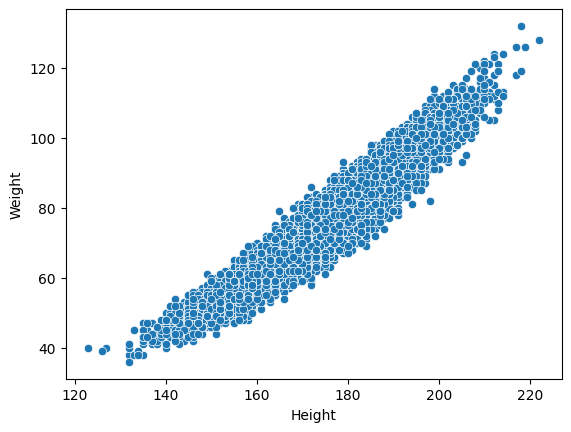

In [7]:
sb.scatterplot(x='Height', y='Weight', data=df)
plt.show()

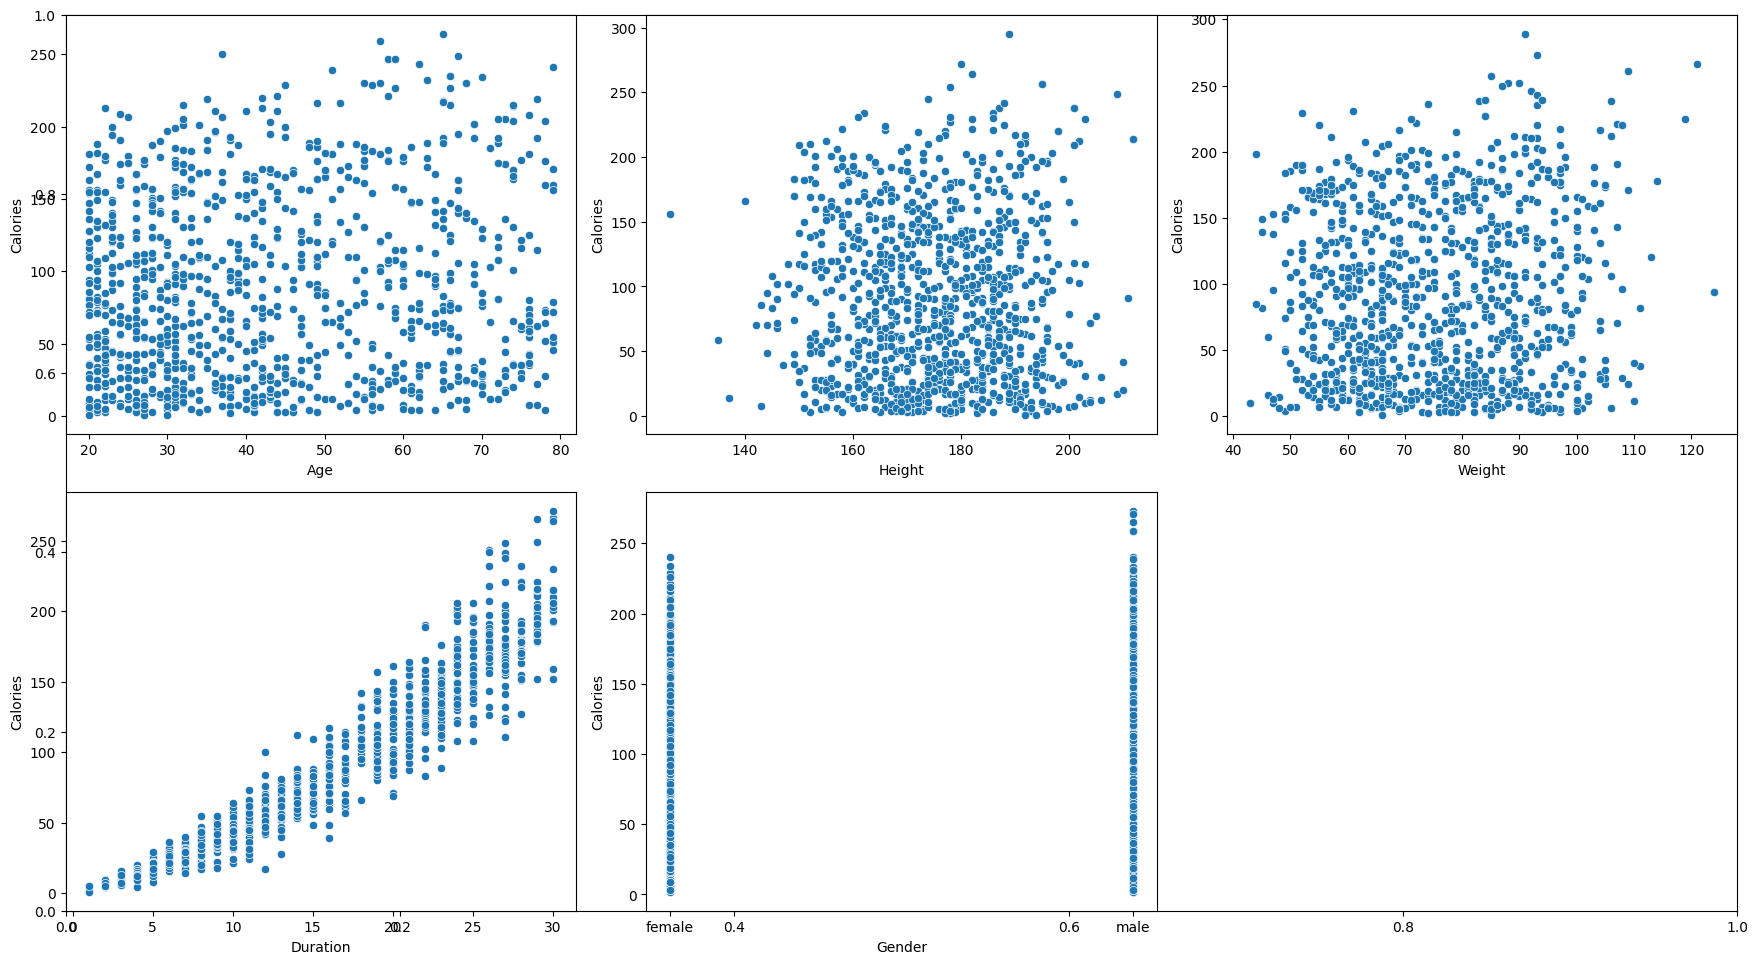

In [8]:
features = ['Age', 'Height', 'Weight', 'Duration', 'Gender']
n_features = len(features)
cols = 3
rows = math.ceil(n_features / cols)
plt.figure
plt.subplots(figsize=(cols * 6, rows * 5))
for i, col in enumerate(features):
    plt.subplot(rows, cols, i+1)
    x = df.sample(1000)
    sb.scatterplot(x=col, y='Calories', data=x)
plt.tight_layout()
plt.show()

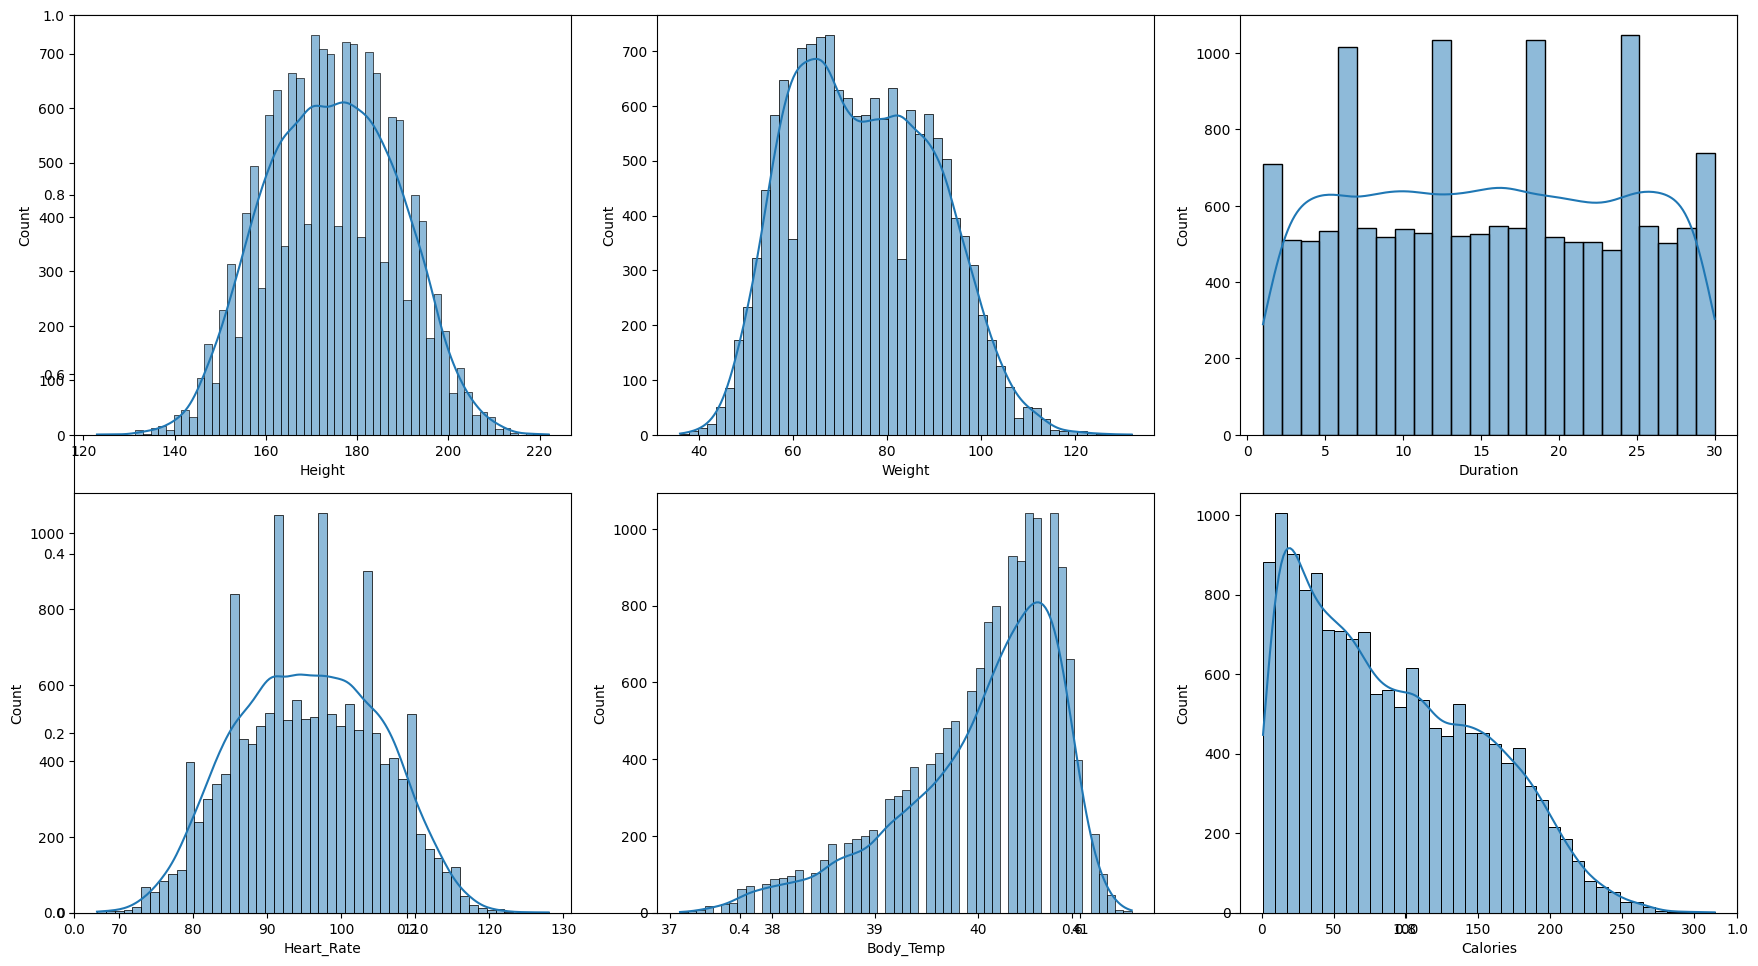

In [9]:
features = df.select_dtypes(include='float').columns
length_features = len(features)
cols = 3
rows = math.ceil(length_features / cols)
plt.subplots(figsize=(cols * 6, rows * 5))
for i, col in enumerate(features):
    plt.subplot(rows, cols, i+1)
    sb.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()

In [10]:
# ===================== DISTRIBUTION INTERPRETATION GUIDE =====================

# Bell-shaped (≈ Normal)
# What you see:
# - Single peak
# - Rough symmetry
# - Smooth density curve
# What it means:
# - Mean ≈ Median
# - Many models handle this well
# What you do:
# - Standard scaling (StandardScaler)
# - No transformation needed


# Right-skewed distribution
# What you see:
# - Peak on the left
# - Long tail to the right
# What it means:
# - Mean > Median
# - Presence of outliers
# What you do:
# - Log or square-root transformation
# - Use robust scaling if needed


# Left-skewed distribution
# What you see:
# - Peak on the right
# - Long tail to the left
# What it means:
# - Mean < Median
# - Possible ceiling effect
# What you do:
# - Reflect and transform
# - Re-evaluate feature usefulness


# Unimodal distribution
# What you see:
# - One clear peak
# What it means:
# - Single population
# - Clean signal
# What you do:
# - Model directly


# Multimodal distribution
# What you see:
# - Two or more peaks
# What it means:
# - Mixed subpopulations
# - Hidden groups in data
# What you do:
# - Segment data
# - Add grouping or interaction features


# Narrow distribution
# What you see:
# - Values tightly clustered
# What it means:
# - Low variance
# - Possibly weak feature
# What you do:
# - Check correlation
# - Consider dropping if not informative


# Wide distribution
# What you see:
# - Values spread over a wide range
# What it means:
# - High variance
# - Potentially strong signal
# What you do:
# - Apply feature scaling


# Outliers present
# What you see:
# - Extreme values far from main mass
# What it means:
# - Rare but influential observations
# What you do:
# - Investigate source
# - Cap, remove, or transform


# Zero-inflated distribution
# What you see:
# - Large spike at zero (or constant value)
# What it means:
# - Structural zeros
# - Two different behaviors
# What you do:
# - Create binary indicator (zero vs non-zero)
# - Consider two-stage modeling


In [11]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0


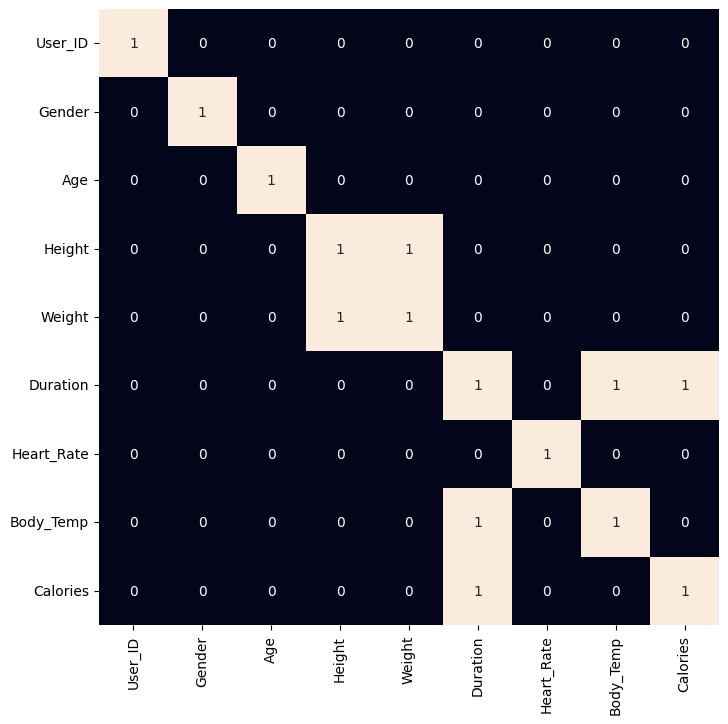

In [12]:
plt.figure(figsize=(8,8))
sb.heatmap(df.corr() > 0.9,
        annot=True,
        cbar=False)
plt.show()

In [13]:
to_remove = ['Weight', 'Duration']
df.drop(to_remove, axis=1, inplace=True)

In [14]:
df.corr()['Calories'].sort_values(ascending=False)


Calories      1.000000
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Gender        0.022357
Height        0.017537
User_ID      -0.001661
Name: Calories, dtype: float64

In [15]:
df.var().sort_values()


Gender        2.500042e-01
Body_Temp     6.071993e-01
Heart_Rate    9.184018e+01
Height        2.032938e+02
Age           2.883294e+02
Calories      3.900874e+03
User_ID       8.253275e+12
dtype: float64

In [16]:
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values
X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)
X_train.shape, X_val.shape

((13500, 5), (1500, 5))

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [18]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(),
          Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  17.893463692619434
Validation Error :  18.007896272831253

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) : 
Training Error :  7.89463304294701
Validation Error :  10.12050432946533

Lasso() : 
Training Error :  17.915089584958036
Validation Error :  17.995

In [ ]:
# BMI did not improve performance because weight was removed due to leakage, reducing BMI’s physical meaning. Additionally, tree-based models benefit more from raw, independent features like height, which allow flexible threshold splits and interactions. Since calorie expenditure in this dataset is dominated by activity intensity rather than body composition, BMI provided little additional predictive power.

In [19]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=22
)

xgb.fit(X_train, Y_train)

val_preds = xgb.predict(X_val)
mae(Y_val, val_preds)


9.839224817407628

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    xgb,
    features,
    target,
    scoring='neg_mean_absolute_error',
    cv=5
)

print(-scores.mean())

10.03760822880231


In [22]:
df['Calories'].describe()


count    15000.000000
mean        89.539533
std         62.456978
min          1.000000
25%         35.000000
50%         79.000000
75%        138.000000
max        314.000000
Name: Calories, dtype: float64

In [23]:
df['HR_per_Age'] = df['Heart_Rate'] / df['Age']


In [27]:
features = df.drop(['User_ID', 'Calories'], axis=1)
target = df['Calories'].values

X_train, X_val, Y_train, Y_val = train_test_split(
    features, target, test_size=0.1, random_state=22
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


models = [LinearRegression(), XGBRegressor(),
          Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()


LinearRegression() : 
Training Error :  17.87423027962632
Validation Error :  17.99011369968515

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) : 
Training Error :  7.700167649840867
Validation Error :  10.214102302104235

Lasso() : 
Training Error :  17.90737523165639
Validation Error :  17.9881

In [ ]:
#old version is better